# LCLS Cu Injector Surrogate Model  (up to OTR2)

predict $\epsilon_x$, $\epsilon_y$, $\sigma_x$, $\sigma_y$, $\sigma_z$
from NN trained on IMPACT-T simulations


# Links to Sections

* [Initial model info](#init)

* [Build model functions](#build)

* [Model predict](#predict)

* [Model comparison with sim scans](#scan)

* [Model comparison with a corrplot](#meas)



# Imports

In [4]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Activation, GaussianNoise, Reshape,  Conv2D, UpSampling2D
from tensorflow.keras import regularizers, datasets, layers, models
from tensorflow.keras.losses import mse 
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import time
import sys, os
import pickle as pick
import pandas as pd
import json
import array
import random
from math import sqrt
import pickle

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler

<a id="init"></a>
# Initial Info

In [5]:
PATH = ''
NAME = 'v3b_cnsga_'
screen ='OTR2'

In [6]:
with open(PATH+NAME+screen+'_list_dict.json') as json_file:
    json_names = json.load(json_file)

In [7]:
output_names=json_names['out_'+screen+'_vars']
output_names

['n_particle',
 'mean_gamma',
 'sigma_gamma',
 'norm_emit_x',
 'norm_emit_y',
 'sigma_x',
 'sigma_y',
 'sigma_z',
 'sigma_px',
 'sigma_py',
 'sigma_pz',
 'mean_x',
 'mean_y',
 'mean_z',
 'mean_px',
 'mean_py',
 'mean_pz',
 'higher_order_energy_spread',
 'cov_x__px',
 'cov_z__pz',
 'cov_y__py',
 'archive']

In [8]:
input_names = json_names['input_vars']
input_names

['distgen:r_dist:sigma_xy:value',
 'distgen:t_dist:length:value',
 'distgen:total_charge:value',
 'SOL1:solenoid_field_scale',
 'CQ01:b1_gradient',
 'SQ01:b1_gradient',
 'L0A_scale:voltage',
 'L0A_phase:dtheta0_deg',
 'L0B_scale:voltage',
 'L0B_phase:dtheta0_deg']

In [9]:
model_in_list = input_names
model_out_list =['sigma_x','sigma_y','sigma_z','norm_emit_x', 'norm_emit_y']

In [10]:
#note model input variable ranges:
input_mins =[ 2.29557814e-01,  3.00000088e+00,  2.50000000e+02,  2.21046414e-01,
       -9.99734982e-03, -9.99951710e-03,  5.80000000e+07, -2.49996808e+01,
        7.00000000e+07, -2.49941337e+01]

input_maxs= [4.99997494e-01, 1.19929210e+01, 2.50000000e+02, 2.52305929e-01,
       9.92647049e-03, 9.99267544e-03, 5.80000000e+07, 9.99658492e+00,
       7.00000000e+07, 9.99948470e+00]

In [11]:
loc_in = {model_in_list[i]: np.arange(0,len(model_in_list))[i] for i in range(len(model_in_list))} 

In [12]:
loc_out = {model_out_list[i]: np.arange(0,len(model_out_list))[i] for i in range(len(model_out_list))} 

In [13]:

#load scaler for transforming data before sending to NN
scalerfile = 'transformer_x.sav'
transformer_x = pickle.load(open(scalerfile, 'rb'))
scalerfile = 'transformer_y.sav'
transformer_y = pickle.load(open(scalerfile, 'rb'))

In [14]:
#conversions between sim and machine: 
#sim units /factor = measured units
#measured units * factor = sim units

sol_sim_factor = 0.51427242
quad_sim_factor = -0.476190476 

<a id="build"></a>
# Define Model

In [15]:
# manual scaling
def build_ff_sc2sc(in_dim_scalar = 4, 
                               out_dim_scalar = 4,
                               l1 = 8, l2 = 6, l3 = 4, l4 = 4, l5 = 4,l6=10,l7=10,l8=10,l9=10, 
                               opt = 'adam', 
                               loss = 'mse', 
                               act = 'tanh', 
                               l2reg = 0.00000):
    
    
    layer_in = Input(shape=(in_dim_scalar,))
    layer_ = Dense(l1, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_in)
    layer_ = Dense(l2, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l3, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l4, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l5, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l6, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_) 
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l7, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l8, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dense(l9, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_out = Dense(out_dim_scalar, activation='linear')(layer_)
    
    
    model = Model(inputs=layer_in, outputs=layer_out)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model

In [16]:
MODEL_PATH = './'

In [17]:
MODEL_NAME = 'model_OTR_rms_emit'

In [18]:
model_1=load_model(MODEL_PATH + MODEL_NAME+'.h5')

In [19]:
savepath = MODEL_PATH +'figures/'



<a id="predict"></a>



# Model Predict Example

In [20]:
#input and output are full scale values

def model_pred(x):
    
    x =  transformer_x.transform(x)
    y = model_1.predict(x)
    y = transformer_y.inverse_transform(y)
    
    return np.exp(y)

In [21]:
X_true = np.load('x_raw_small.npy')
Y_true = np.load('y_raw_small.npy')

In [22]:
# make predictions
Y_pred = model_pred(X_true)

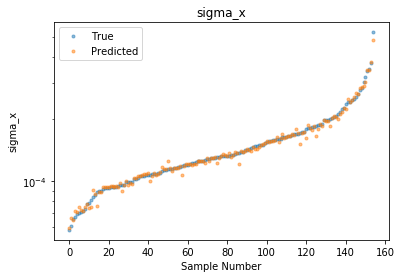

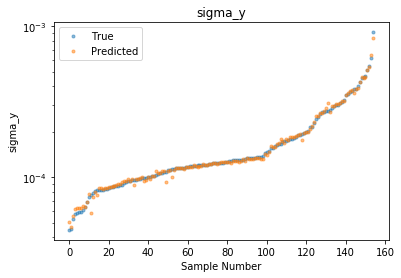

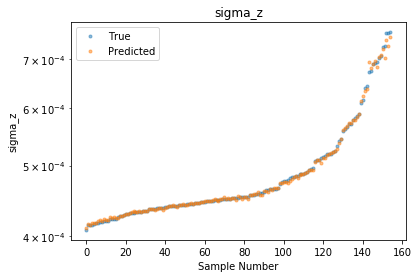

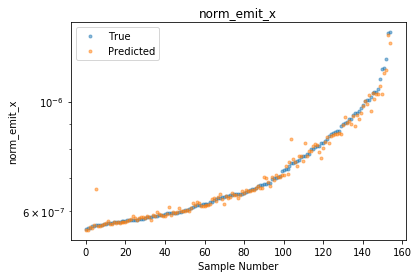

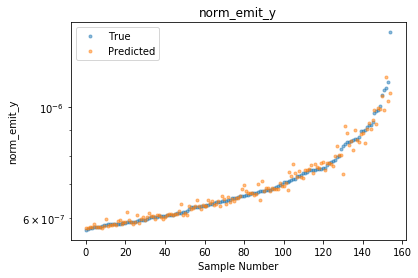

In [23]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(model_out_list[i])
    plt.ylabel(model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted'])
    plt.show()

### load some nominally optimal points from simulation to run

In [26]:
scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]

#load from first scan
dat1 = json.load(open(PATH+scanlist[0]))
inputs=pd.DataFrame(dat1['inputs'])
outputs=pd.DataFrame(dat1['outputs'])

#select only model inputs and outputs
inputs = inputs[model_in_list];

#for this run looking at slightly z in simulation, model will be off a bit
model_out_list2=['end_'+s for s in model_out_list]

outputs = outputs[model_out_list2];

#select first row
ref_input_values = np.asarray(inputs[0:1])



In [30]:
# make predictions
Y_pred = model_pred(ref_input_values)

Y_pred

array([[5.0493679e-04, 8.3292008e-04, 4.5215926e-04, 1.1734467e-06,
        1.1347942e-06]], dtype=float32)



<a id="scan"></a>



# Compare with 1-D Scans from Simulation Around Optimum 
### (likely not well-sampled in training)

In [21]:
# run a scal using scanlist -- (TODO later should be a clean, separate general scan function )

def do_scan_at_OTR2(numscan=100,scanpath = '/gpfs/slac/staas/fs1/g/accelerator_modeling/edelen/LCLS_CU_full/sims/scan/'):
    
    scan_idx={'SOL1:solenoid_field':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    print(' ')
    print('SOL1:solenoid_field_scale')
    print(' ')  
    
    FIGNAME= 'SOL_'


    inputs = inputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_in_list];


    outputs = outputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_out_list];
    scan = np.linspace(0.01,1,numscan)
    
    mine = 5.461418942827289e-07
    
    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])
    
    x_scan=transformer_x.transform(x_raw_scan)
    
    x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan
    
    Y_pred_scalar = model_1.predict(x_scan)
    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)
    
    x_scan2=transformer_x.transform(inputs)
    
    Y_pred_scalar2 = model_1.predict(x_scan2)
    
    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_x.png',bbox_inches='tight')
    plt.show()
    
    
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emit_y.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    plt.ylim([0.43,0.51])
    plt.show()
    
    
    print(' ')
    print('SQ01:b1_gradient')
    print(' ')  
    


    FIGNAME= 'SQ01_'

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    inputs = inputs[scan_idx['SQ01:b1_gradient'][0]:scan_idx['SQ01:b1_gradient'][1]][model_in_list];


    outputs = outputs[scan_idx['SQ01:b1_gradient'][0]:scan_idx['SQ01:b1_gradient'][1]][model_out_list];


    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['SQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    #plt.ylim([mine*10**,1])
    plt.show()
    
    print(' ')
    print('CQ01:b1_gradient')
    print(' ')  
    

    FIGNAME = 'CQ10_'

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    inputs = inputs[scan_idx['CQ01:b1_gradient'][0]:scan_idx['CQ01:b1_gradient'][1]][model_in_list];


    outputs = outputs[scan_idx['CQ01:b1_gradient'][0]:scan_idx['CQ01:b1_gradient'][1]][model_out_list];


    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['CQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)



    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])

    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()    


    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')

    #plt.ylim([mine*10**,1])
    plt.show()

    return


 
SOL1:solenoid_field_scale
 


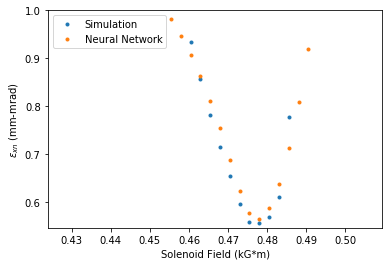

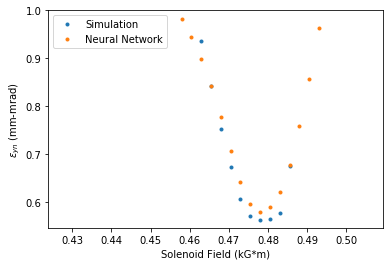

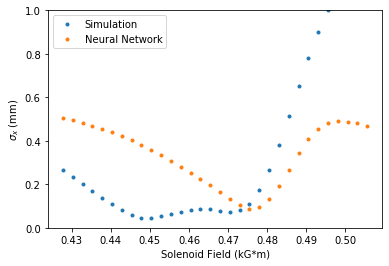

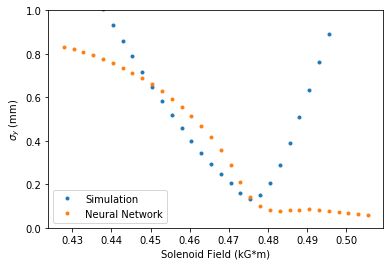

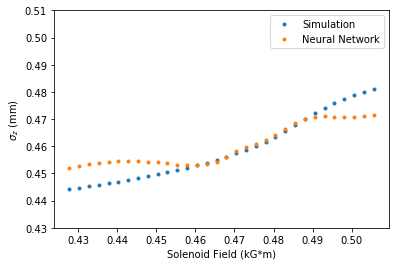

 
SQ01:b1_gradient
 


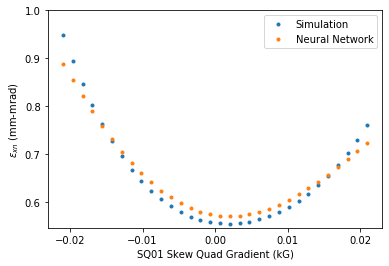

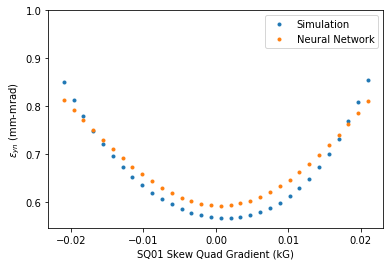

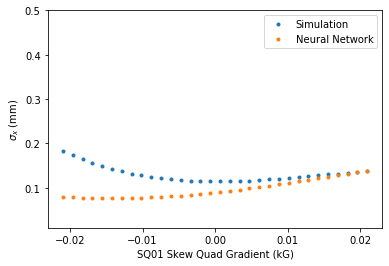

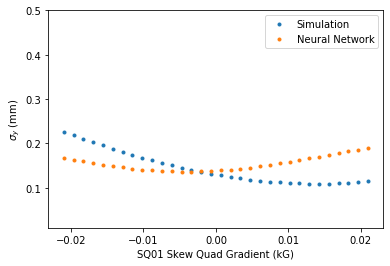

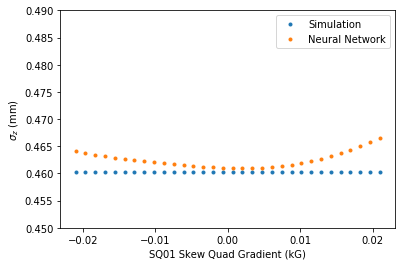

 
CQ01:b1_gradient
 


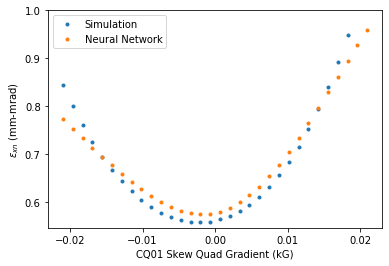

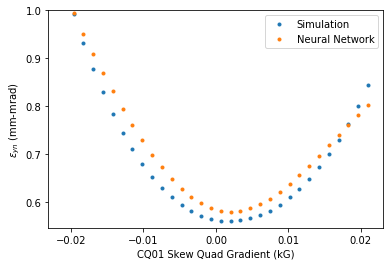

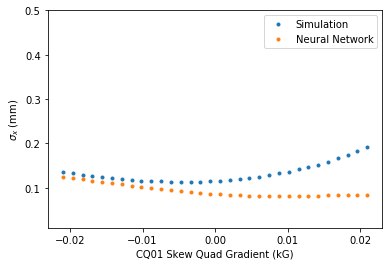

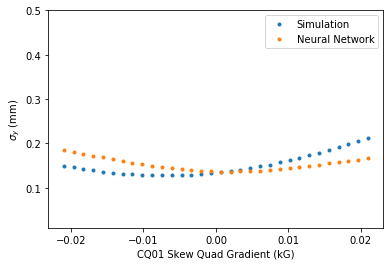

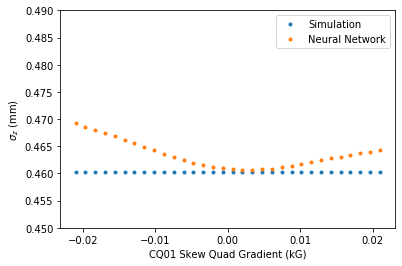

In [22]:
do_scan_at_OTR2()

In [23]:
# run a scal using scanlist -- (TODO later should be a clean, separate general scan function )

def do_scan_at_z16m(numscan=100, scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]):
    
    
        
    print(' ')
    print('SOL1:solenoid_field_scale')
    print(' ')  
    
    FIGNAME= 'SOL_'
    dat1 = json.load(open(PATH+scanlist[0]))
    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];
    scan = np.linspace(0.01,1,numscan)
    
    mine = 5.461418942827289e-07
    
    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])
    
    x_scan=transformer_x.transform(x_raw_scan)
    
    x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan
    
    Y_pred_scalar = model_1.predict(x_scan)
    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)
    
    x_scan2=transformer_x.transform(inputs)
    
    Y_pred_scalar2 = model_1.predict(x_scan2)
    
    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_x.png',bbox_inches='tight')
    plt.show()
    
    
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emit_y.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    plt.ylim([0.43,0.51])
    plt.show()
    
    
    print(' ')
    print('SQ01:b1_gradient')
    print(' ')  
    
    dat1 = json.load(open(PATH+scanlist[1]))

    FIGNAME= 'SQ01_'

    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];

    #Scans
    numscan=100
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['SQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    #plt.ylim([mine*10**,1])
    plt.show()
    
    print(' ')
    print('CQ01:b1_gradient')
    print(' ')  
    
    dat1 = json.load(open(PATH+scanlist[2]))

    FIGNAME = 'CQ10_'

    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];

    #Scans
    numscan=100
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['CQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)



    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])

    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()    


    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')

    #plt.ylim([mine*10**,1])
    plt.show()

    return


 
SOL1:solenoid_field_scale
 


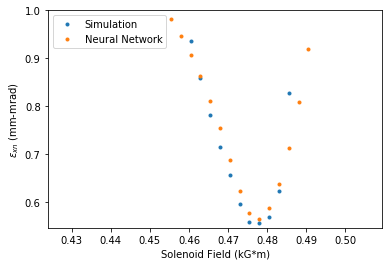

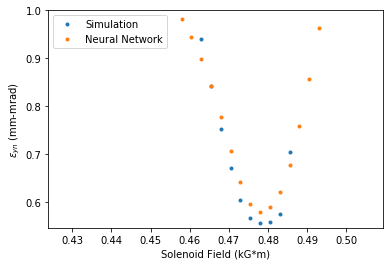

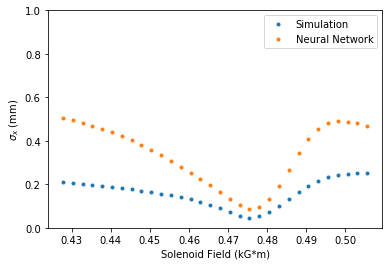

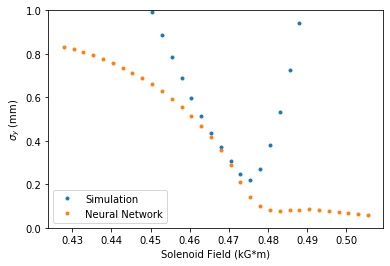

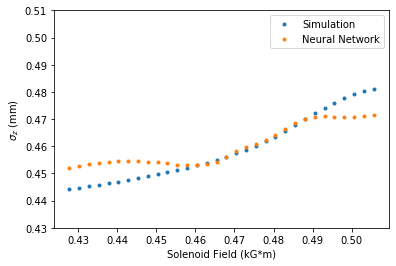

 
SQ01:b1_gradient
 


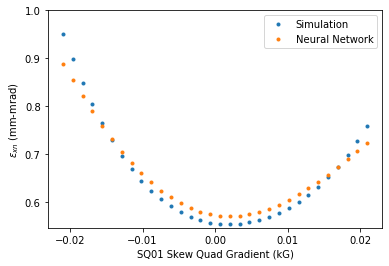

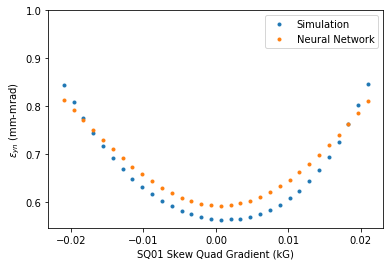

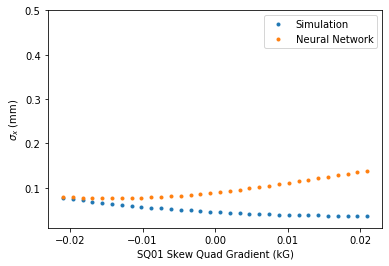

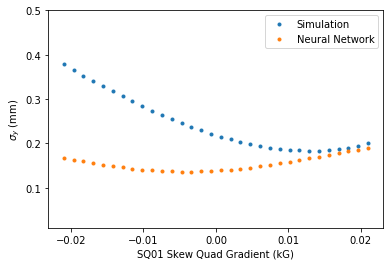

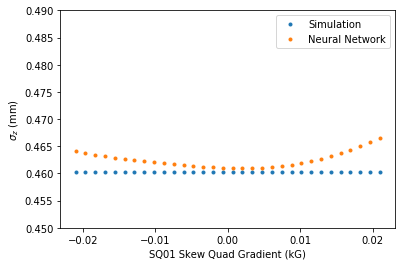

 
CQ01:b1_gradient
 


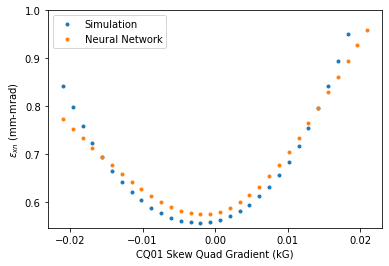

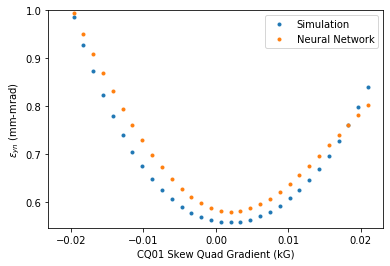

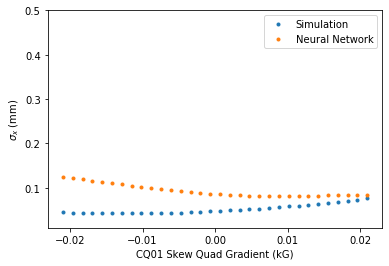

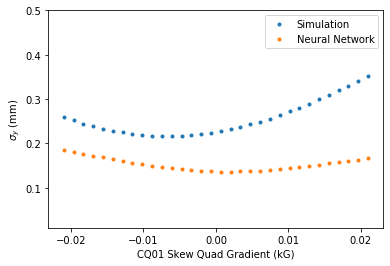

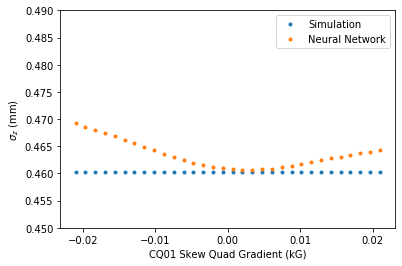

In [24]:
 do_scan_at_z16m(numscan=100, scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',])



<a id="meas"></a>


# Comparison with some measured data 
(note guessing on some of these inputs other than SQ/CQ/SOL, so not expected to be exact)

In [25]:
emitx=[1.4085,1.4305,1.0905, 0.7137,0.5358, 0.5075,0.6359,1.1666,2.4465]
emity=[2.5192, 1.7998, 0.6448, 0.6579, 0.5244, 0.5686, 0, 2.5051, 11.7213]

In [26]:
#CQ and SQ and SO
c=-0.0024
s=0
sol=np.asarray([0.440000000000000,0.445000000000000,
                0.450000000000000,0.455000000000000,
                0.460000000000000,0.465000000000000,
                0.470000000000000,0.475000000000000,0.480000000000000])

(4e-07, 3)

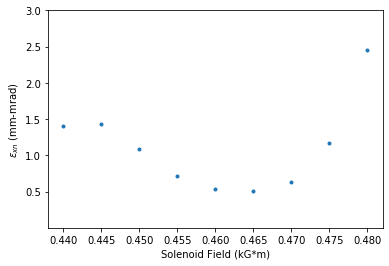

In [27]:
plt.plot(sol,emitx,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,3])

(4e-07, 5)

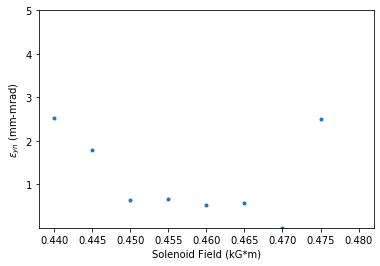

In [28]:
plt.plot(sol,emity,'.')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,5])

In [29]:
#get some inputs for other values
numscan=100
#dat1 = json.load(open(PATH+'scan_SOL1:solenoid_field_scale-fine2.json'))
#inputs=pd.DataFrame(dat1['inputs'])
#outputs=pd.DataFrame(dat1['outputs'])
#inputs = inputs[model_in_list];
#model_out_list2=['end_'+s for s in model_out_list]
#outputs = outputs[model_out_list2];



In [40]:
#get scan data

scanpath = ''

scan_idx={'SOL1:solenoid_field':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

inputs=pd.DataFrame(inputs,columns=input_names)

outputs=pd.DataFrame(outputs,columns=output_names)


inputs = inputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_in_list];


outputs = outputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_out_list];

mine = 5.461418942827289e-07
x_raw_scan=np.empty((numscan,len(model_in_list)))
x_raw_scan[:,:]=np.asarray(inputs[0:1])

scan = np.linspace(0.01,1.2,numscan)

x_raw_scan=np.empty((numscan,len(model_in_list)))
x_raw_scan[:,:]=np.asarray(inputs[0:1])

x_raw_scan[:,loc_in['CQ01:b1_gradient']]=c*quad_sim_factor

x_raw_scan[:,loc_in['SQ01:b1_gradient']]=s*quad_sim_factor

x_scan=transformer_x.transform(x_raw_scan)

x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan


In [41]:
Y_pred_scalar = model_1.predict(x_scan)
Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
X_scan = transformer_x.inverse_transform(x_scan)

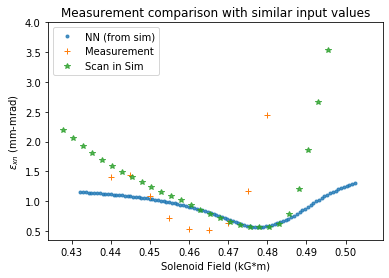

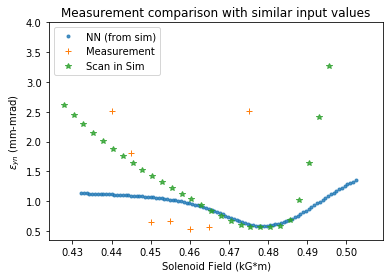

In [42]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,4])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.plot(sol,emity,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_y']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,4])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

## zoom in

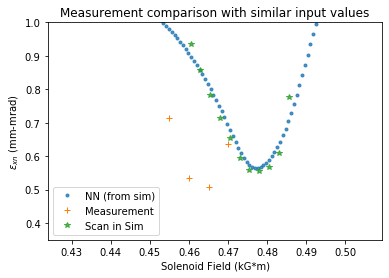

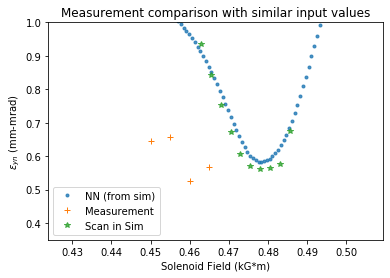

In [36]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.plot(sol,emity,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_y']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()